<a href="https://colab.research.google.com/github/WenyiYao/covtype/blob/main/cnn_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cpu")#"cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# variable information
print(covertype.variables)

                                  name     role     type demographic  \
0                            Elevation  Feature  Integer        None   
1                               Aspect  Feature  Integer        None   
2                                Slope  Feature  Integer        None   
3     Horizontal_Distance_To_Hydrology  Feature  Integer        None   
4       Vertical_Distance_To_Hydrology  Feature  Integer        None   
5      Horizontal_Distance_To_Roadways  Feature  Integer        None   
6                        Hillshade_9am  Feature  Integer        None   
7                       Hillshade_Noon  Feature  Integer        None   
8                        Hillshade_3pm  Feature  Integer        None   
9   Horizontal_Distance_To_Fire_Points  Feature  Integer        None   
10                     Wilderness_Area  Feature  Integer        None   
11                          Soil_Type1  Feature  Integer        None   
12                          Soil_Type2  Feature  Integer        

In [5]:
# check missing value
covertype.data.features.isnull().sum().sum()

0

In [6]:
# check data type
covertype.data.features.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area                       int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                            int64
Soil_Type10                           int64
Soil_Type11                           int64
Soil_Type12                     

In [7]:
X = covertype.data.features.iloc[:,0:51]
y = covertype.data.features.Cover_Type

In [8]:
X.head()

,,,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
2596,51,3,258,0,510,221,232,148,6279,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2804,139,9,268,65,3180,234,238,135,6121,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2785,155,18,242,118,3090,238,238,122,6211,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,45,2,153,-1,391,220,234,150,6172,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y.unique()

array([5, 2, 1, 7, 3, 6, 4])

In [10]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Convert data to PyTorch tensors
# X_train_cnn = X_train.reshape(-1, 1, 1, 51)
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.to_numpy() - 1).to(device)  # Subtract 1 to make classes 0-indexed
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.to_numpy() - 1).to(device)  # Subtract 1 to make classes 0-indexed

In [13]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        #self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 25, 128)
        self.fc2 = nn.Linear(128, 7)  # 7 classes for cover types

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
# Initialize the CNN model
model = CNNModel()

In [15]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Convert data to DataLoader
train_dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor.unsqueeze(1), y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [17]:
# Move Model and Data to GPU
model = model.to(device)

In [18]:
# get accuracy
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [19]:
# Training the model
num_epochs = 10
train_loss_history = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_epoch_loss)
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    test_acc.append(get_accuracy(model, test_loader))  # compute validation accuracy

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}")

Epoch [1/10] Loss: 0.7070
Epoch [2/10] Loss: 0.6415
Epoch [3/10] Loss: 0.7159
Epoch [4/10] Loss: 0.4908
Epoch [5/10] Loss: 0.5602
Epoch [6/10] Loss: 0.7021
Epoch [7/10] Loss: 0.4641
Epoch [8/10] Loss: 0.7177
Epoch [9/10] Loss: 0.5281
Epoch [10/10] Loss: 0.2875


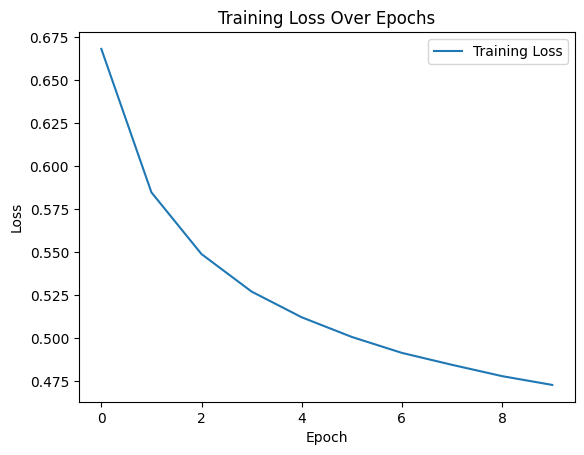

In [20]:
# Plot the loss over epochs
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor.unsqueeze(1))
    _, test_predicted = torch.max(test_outputs, 1)
    accuracy = (test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    print(f"Test Accuracy: {accuracy * 100:.3f}%")

Test Accuracy: 79.406%
